In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
#
import os
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#
from sklearn.preprocessing import LabelEncoder
make_lb = LabelEncoder()
#
from sklearn.preprocessing import LabelBinarizer
lbb = LabelBinarizer()
#
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
#
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#
import pickle
#
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
# 
from sklearn.model_selection import GridSearchCV


---

## EDA

In [ ]:
listings.shape

In [ ]:
listings.dropna(inplace=True)

In [4]:
listings.dropna(subset=['host_response_rate'], inplace=True)

In [6]:
listings.reset_index(drop=True, inplace=True)

In [21]:
listings['host_response_rate'] = listings['host_response_rate'].map(lambda x: x.replace('%', ''))
# listings['price'] = listings['price'].map(lambda x: x.replace('$', ''))
listings['price'] = listings['price'].map(lambda x: x.replace(',', ''))

In [22]:
listings['price'] = listings['price'].astype('float')

In [23]:
# Making np.arrays of prices from different host response rates
pr_100 = np.where(listings['host_response_rate']==100, listings['price'], 0)
prn_100 = np.where(listings['host_response_rate']<100, listings['price'], 0)


In [33]:
# Refining the lists to only include valid prices
# For each type of response rate
prf_100 = []
for num in pr_100:
    if num > 0:
        prf_100.append(num)
prnf_100 = []
for num in prn_100:
    if num > 0:
        prnf_100.append(num)

In [35]:
# Two sample t test to see if the means are significantly different
stats.ttest_ind(prnf_100, prf_100, equal_var=True)

Ttest_indResult(statistic=-3.0144974230202326, pvalue=0.0025831059310148685)

Cannot conclude that those who respond 100% of the time have higher prices than those who do not respond 100% of the time.

In [36]:
listings = listings[['host_is_superhost', 'host_total_listings_count',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable']]

In [38]:
listings.shape

(7136, 18)

In [7]:
listings2 = pd.read_csv('listingsclean2.csv')

In [8]:
listings2.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

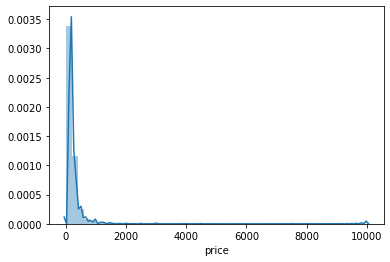

In [9]:
sns.distplot(listings2['price'])

In [10]:
listings2['price'].describe()

count     7114.000000
mean       219.825274
std        407.912788
min          0.000000
25%         99.000000
50%        150.000000
75%        232.000000
max      10000.000000
Name: price, dtype: float64

In [11]:
listings2 = listings2[listings2['price'] <= 1000]

In [12]:
listings2.isnull().sum()

host_response_rate           0
host_is_superhost            0
host_total_listings_count    0
neighbourhood_cleansed       0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
price                        0
guests_included              0
extra_people                 0
minimum_nights               0
number_of_reviews            0
review_scores_rating         0
instant_bookable             0
dtype: int64

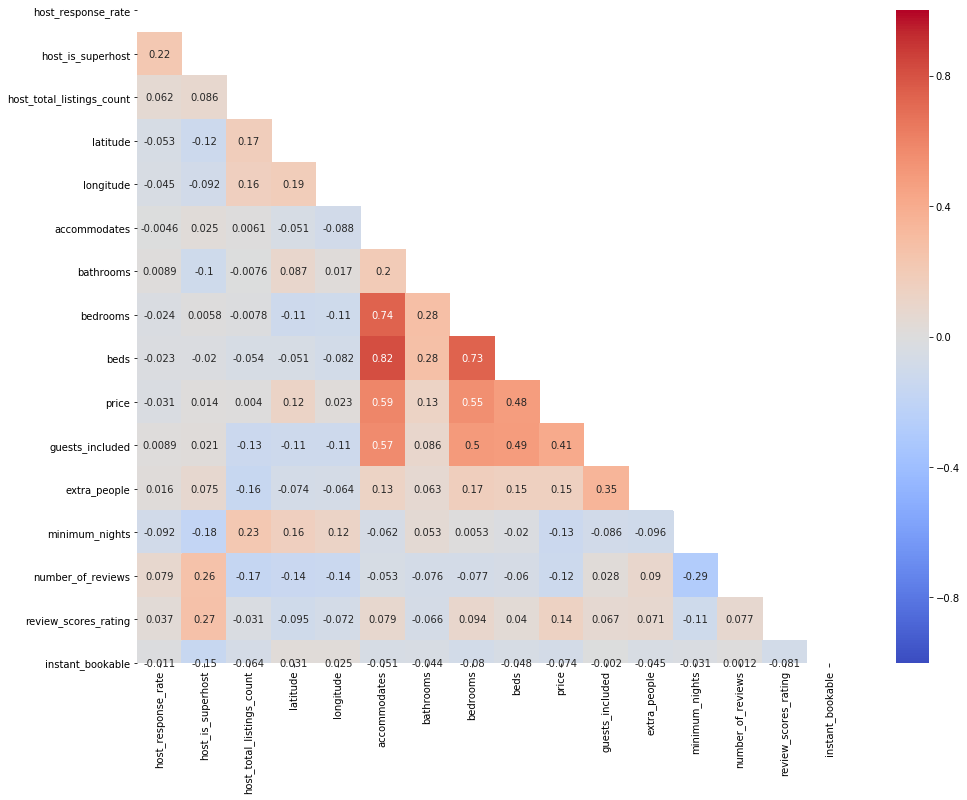

In [13]:
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(listings2.corr())
sns.heatmap(listings2.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

In [14]:
listings2 = listings2[listings2['minimum_nights'] < 59]

In [15]:
listings2

,host_response_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable
0,100,1,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1.0,1.0,2.0,170.0,2,25.0,1,217,97.000000,0
1,100,1,2.0,Inner Sunset,37.75402,-122.45805,House,Private room,2,1.0,1.0,1.0,99.0,2,20.0,1,160,94.000000,0
2,80,0,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1.0,2.0,3.0,235.0,2,0.0,30,111,98.000000,0
3,86,1,10.0,Haight Ashbury,37.76669,-122.45250,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,18,86.000000,0
4,86,1,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,8,93.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,100,0,1.0,Downtown/Civic Center,37.78254,-122.41775,Apartment,Entire home/apt,3,1.0,2.0,2.0,100.0,1,0.0,50,0,90.798403,0
7110,100,0,0.0,Mission,37.75994,-122.41180,Apartment,Entire home/apt,4,1.0,0.0,1.0,250.0,1,0.0,2,0,96.132800,1
7111,100,0,9.0,Downtown/Civic Center,37.77799,-122.42159,Condominium,Entire home/apt,4,1.0,1.0,2.0,200.0,1,0.0,1,0,90.798403,1
7112,78,0,6.0,Bayview,37.73410,-122.38917,Hut,Private room,1,2.0,1.0,0.0,69.0,1,0.0,30,0,94.083832,1


In [16]:
listings2.groupby('neighbourhood_cleansed')['price'].sum()

neighbourhood_cleansed
Bayview                   20561.0
Bernal Heights            57948.0
Castro/Upper Market       80943.0
Chinatown                 22318.0
Crocker Amazon             3963.0
Diamond Heights            3186.0
Downtown/Civic Center     97126.0
Excelsior                 19645.0
Financial District        28969.0
Glen Park                 13791.0
Golden Gate Park           1394.0
Haight Ashbury            70353.0
Inner Richmond            40072.0
Inner Sunset              26743.0
Lakeshore                 10475.0
Marina                    40321.0
Mission                  119859.0
Nob Hill                  46922.0
Noe Valley                62372.0
North Beach               29525.0
Ocean View                12093.0
Outer Mission             23955.0
Outer Richmond            26989.0
Outer Sunset              37035.0
Pacific Heights           34347.0
Parkside                  17293.0
Potrero Hill              47036.0
Presidio                    105.0
Presidio Heights         

In [17]:
rev = list(listings2.groupby('property_type')['price'].sum())
types = list(listings2.groupby('property_type')['price'].sum().keys())

[Text(0, 0, 'Aparthotel'),
 Text(0, 0, 'Apartment'),
 Text(0, 0, 'Bed and breakfast'),
 Text(0, 0, 'Boutique hotel'),
 Text(0, 0, 'Bungalow'),
 Text(0, 0, 'Cabin'),
 Text(0, 0, 'Camper/RV'),
 Text(0, 0, 'Castle'),
 Text(0, 0, 'Condominium'),
 Text(0, 0, 'Cottage'),
 Text(0, 0, 'Dome house'),
 Text(0, 0, 'Earth house'),
 Text(0, 0, 'Guest suite'),
 Text(0, 0, 'Guesthouse'),
 Text(0, 0, 'Hostel'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'House'),
 Text(0, 0, 'Hut'),
 Text(0, 0, 'In-law'),
 Text(0, 0, 'Loft'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Resort'),
 Text(0, 0, 'Serviced apartment'),
 Text(0, 0, 'Tiny house'),
 Text(0, 0, 'Townhouse'),
 Text(0, 0, 'Villa')]

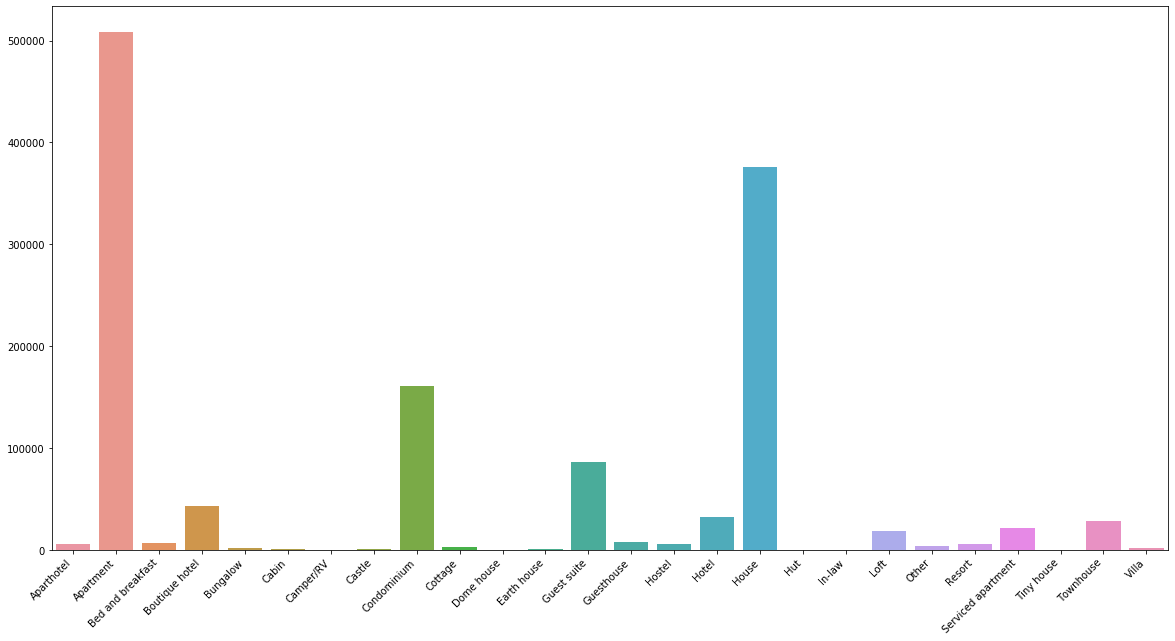

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
chart = sns.barplot(x=types, y=rev)
chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45, horizontalalignment='right')

In [19]:
listings2.price.sum()

1318165.0

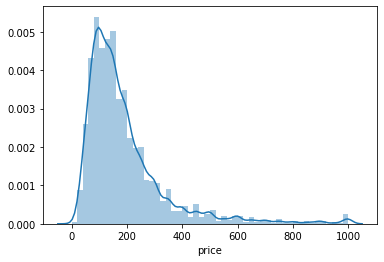

In [20]:
sns.distplot(listings2.price)

In [21]:
(2818+1982+676+542)

6018

In [22]:
listings2.property_type.value_counts()

Apartment             2818
House                 1982
Condominium            676
Guest suite            542
Boutique hotel         228
Hotel                  128
Townhouse              123
Serviced apartment     110
Hostel                  78
Loft                    64
Bed and breakfast       43
Aparthotel              40
Guesthouse              38
Other                   21
Resort                  12
Cottage                 11
Bungalow                11
Villa                    9
Castle                   4
Cabin                    3
Tiny house               2
Earth house              2
Hut                      1
Dome house               1
In-law                   1
Camper/RV                1
Name: property_type, dtype: int64

In [23]:
props = list(listings2.property_type.value_counts().keys())
counts = list(listings2.property_type.value_counts())

[Text(0, 0, 'Apartment'),
 Text(0, 0, 'House'),
 Text(0, 0, 'Condominium'),
 Text(0, 0, 'Guest suite'),
 Text(0, 0, 'Boutique hotel'),
 Text(0, 0, 'Hotel'),
 Text(0, 0, 'Townhouse'),
 Text(0, 0, 'Serviced apartment'),
 Text(0, 0, 'Hostel'),
 Text(0, 0, 'Loft'),
 Text(0, 0, 'Bed and breakfast'),
 Text(0, 0, 'Aparthotel'),
 Text(0, 0, 'Guesthouse'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Resort'),
 Text(0, 0, 'Cottage'),
 Text(0, 0, 'Bungalow'),
 Text(0, 0, 'Villa'),
 Text(0, 0, 'Castle'),
 Text(0, 0, 'Cabin'),
 Text(0, 0, 'Tiny house'),
 Text(0, 0, 'Earth house'),
 Text(0, 0, 'Hut'),
 Text(0, 0, 'Dome house'),
 Text(0, 0, 'In-law'),
 Text(0, 0, 'Camper/RV')]

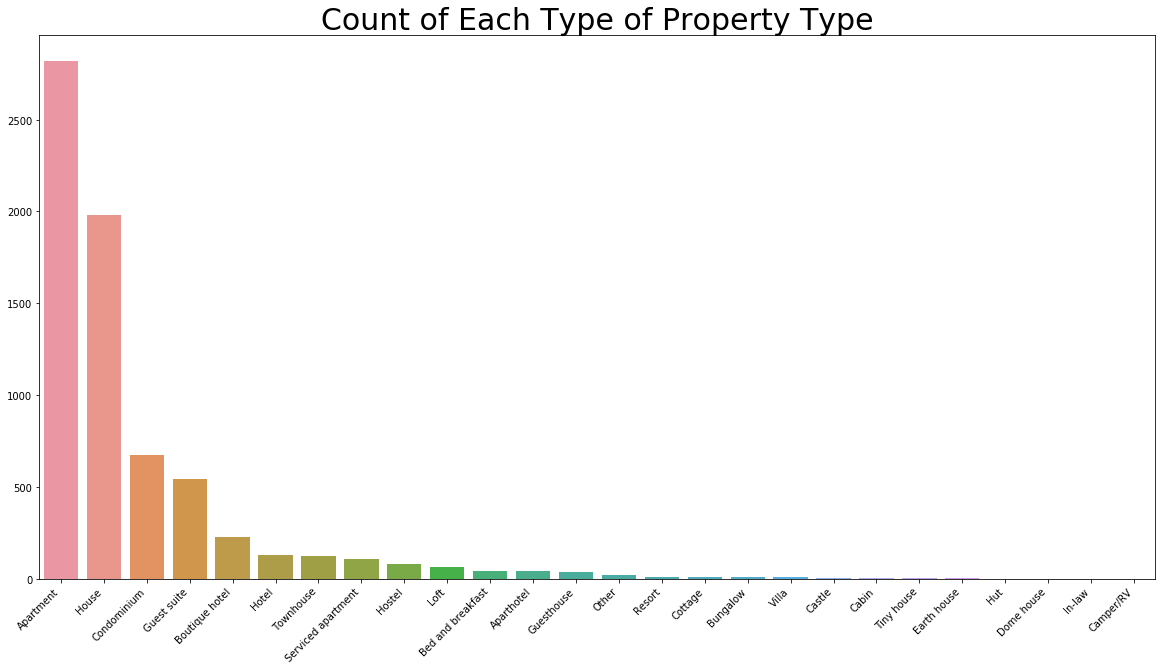

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
chart2 = sns.barplot(x=props, y=counts)
plt.title('Count of Each Type of Property Type', fontsize=30)
chart2.set_xticklabels(chart2.get_xticklabels(),
                      rotation=45, horizontalalignment='right')

In [25]:
listings2_cut = listings2[(listings2['property_type'] == 'Apartment') | 
                         (listings2['property_type'] == 'House') | 
                         (listings2['property_type'] == 'Condominium') |
                         (listings2['property_type'] == 'Guest suite')]

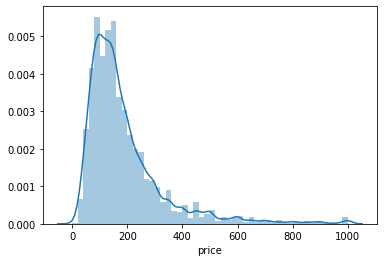

In [26]:
sns.distplot(listings2_cut.price)

Dropping most of the property types because we are looking for certain types of clients.

In [29]:
listings2_cut.room_type.value_counts()

Entire home/apt    3741
Private room       2118
Shared room         159
Name: room_type, dtype: int64

In [30]:
listings2_cut = listings2_cut[listings2_cut['room_type'] != 'Shared room']

In [31]:
listings2_cut.shape

(5859, 19)

In [32]:
listings2_cut

,host_response_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable
0,100,1,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1.0,1.0,2.0,170.0,2,25.0,1,217,97.000000,0
1,100,1,2.0,Inner Sunset,37.75402,-122.45805,House,Private room,2,1.0,1.0,1.0,99.0,2,20.0,1,160,94.000000,0
2,80,0,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1.0,2.0,3.0,235.0,2,0.0,30,111,98.000000,0
3,86,1,10.0,Haight Ashbury,37.76669,-122.45250,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,18,86.000000,0
4,86,1,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,8,93.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108,75,0,4.0,Financial District,37.78879,-122.39321,Condominium,Entire home/apt,6,1.5,1.0,3.0,299.0,1,35.0,1,0,94.774194,1
7109,100,0,1.0,Downtown/Civic Center,37.78254,-122.41775,Apartment,Entire home/apt,3,1.0,2.0,2.0,100.0,1,0.0,50,0,90.798403,0
7110,100,0,0.0,Mission,37.75994,-122.41180,Apartment,Entire home/apt,4,1.0,0.0,1.0,250.0,1,0.0,2,0,96.132800,1
7111,100,0,9.0,Downtown/Civic Center,37.77799,-122.42159,Condominium,Entire home/apt,4,1.0,1.0,2.0,200.0,1,0.0,1,0,90.798403,1


In [33]:
room = pd.get_dummies(listings2_cut['room_type'], prefix='room', drop_first=True)
nbrhd = pd.get_dummies(listings2_cut['neighbourhood_cleansed'], prefix='nbrhd', drop_first=True)
prop = pd.get_dummies(listings2_cut['property_type'], prefix='prop', drop_first=True)


In [34]:
listings2_cut.drop(columns=['room_type', 'neighbourhood_cleansed', 'property_type'], axis=1, inplace=True)

In [ ]:
list_

In [39]:
list_working = pd.concat([listings2_cut, room, nbrhd, prop], axis=1)

In [41]:
list_working.shape

(5859, 55)

In [44]:
list_working.to_csv('list_working.csv')

In [48]:
list_working.head()

,host_response_rate,host_is_superhost,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,nbrhd_Russian Hill,nbrhd_Seacliff,nbrhd_South of Market,nbrhd_Twin Peaks,nbrhd_Visitacion Valley,nbrhd_West of Twin Peaks,nbrhd_Western Addition,prop_Condominium,prop_Guest suite,prop_House
0,100,1,1.0,37.76931,-122.43386,3,1.0,1.0,2.0,170.0,...,0,0,0,0,0,0,1,0,0,0
1,100,1,2.0,37.75402,-122.45805,2,1.0,1.0,1.0,99.0,...,0,0,0,0,0,0,0,0,0,1
2,80,0,2.0,37.74511,-122.42102,5,1.0,2.0,3.0,235.0,...,0,0,0,0,0,0,0,0,0,0
3,86,1,10.0,37.76669,-122.45250,2,4.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,0
4,86,1,10.0,37.76487,-122.45183,2,4.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
target = list_working.price
data = list_working.drop(columns='price', axis=1)

In [68]:
def test_models3(data, target, num_iter=5, models=['ols', 'ridge', 'lasso'], alpha=10,
                 complexity='simple', degree=2):

    models = {}
    model_metrics = {}

    for i in range(num_iter):
        if 'ols' in models:
            if complexity == 'simple':
                X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)
            
                linreg = LinearRegression()
                ols_model = linreg.fit(X_train, Y_train)
                Y_train_pred = ols_model.predict(X_train)
                Y_test_pred = ols_model.predict(X_test)
                models['ols'] = ols_model
                print(ols_model.score(X_test, Y_test))
                print(ols_model.score(X_train, Y_train))
                print(np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
                print(np.sqrt(mean_squared_error(Y_train, Y_train_pred)))
            else:
                poly = PolynomialFeatures(degree=degree)
                Xp = poly.fit_transform(data)
                X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
        
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)

                linreg = LinearRegression()
                ols_model = linreg.fit(X_train, Y_train)
                Y_train_pred = ols_model.predict(X_train)
                Y_test_pred = ols_model.predict(X_test)
                models['ols'] = ols_model
                print(ols_model.score(X_test, Y_test))
                print(ols_model.score(X_train, Y_train))
                print(np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
                print(np.sqrt(mean_squared_error(Y_train, Y_train_pred)))

#         if 'lasso' in models:
#                 lasso = Lasso(alpha=alpha, max_iter=1000, normalize=True)
#                 lasso_mod = lasso.fit(X_train, Y_train)
#                 models['lasso'] = lasso_mod
#                 Y_train_pred = lasso_mod.predict(X_train)
#                 Y_test_pred = lasso_mod.predict(X_test)

#                 model_metrics['LASSO_test_R2'] = lasso_mod.score(X_test, Y_test)
#                 model_metrics['LASSO_train_R2'] = lasso_mod.score(X_train, Y_train)
#                 model_metrics['LASSO_test_RMSE'] = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
#                 model_metrics['LASSO_train_RMSE'] = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

#             if 'ridge' in models:
#                 ridge = Ridge(alpha=alpha, max_iter=1000, normalize=True)
#                 ridge_mod = ridge.fit(X_train, Y_train)
#                 models['ridge'] = ridge_mod
#                 Y_train_pred = ridge_mod.predict(X_train)
#                 Y_test_pred = ridge_mod.predict(X_test)

#                 model_metrics['RIDGE_test_R2'] = ridge_mod.score(X_test, Y_test)
#                 model_metrics['RIDGE_train_R2'] = ridge_mod.score(X_train, Y_train)
#                 model_metrics['RIDGE_test_RMSE'] = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
#                 model_metrics['RIDGE_train_RMSE'] = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
            
#         else:
#             poly = PolynomialFeatures(degree=degree)
#             Xp = poly.fit_transform(data)
#             X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
        
#             scaler = StandardScaler()
#             X_train = scaler.fit_transform(X_train)
#             X_test = scaler.fit_transform(X_test)

#             if 'ols' in models:
#                 linreg = LinearRegression()
#                 ols_model = linreg.fit(X_train, Y_train)
#                 Y_train_pred = ols_model.predict(X_train)
#                 Y_test_pred = ols_model.predict(X_test)
#                 models['ols'] = ols_model
#                 print(ols_model.score(X_test, Y_test))
#                 print(ols_model.score(X_train, Y_train))
#                 print(np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
#                 print(np.sqrt(mean_squared_error(Y_train, Y_train_pred)))

#             if 'lasso' in models:
#                 lasso = Lasso(alpha=alpha, max_iter=1000, normalize=True)
#                 lasso_mod = lasso.fit(X_train, Y_train)
#                 models['lasso'] = lasso_mod
#                 Y_train_pred = lasso_mod.predict(X_train)
#                 Y_test_pred = lasso_mod.predict(X_test)

#                 model_metrics['LASSO_test_R2'] = lasso_mod.score(X_test, Y_test)
#                 model_metrics['LASSO_train_R2'] = lasso_mod.score(X_train, Y_train)
#                 model_metrics['LASSO_test_RMSE'] = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
#                 model_metrics['LASSO_train_RMSE'] = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
                
#             if 'ridge' in models:
#                 ridge = Ridge(alpha=alpha, max_iter=1000, normalize=True)
#                 ridge_mod = ridge.fit(X_train, Y_train)
#                 models['ridge'] = ridge_mod
#                 Y_train_pred = ridge_mod.predict(X_train)
#                 Y_test_pred = ridge_mod.predict(X_test)
                    
#                 model_metrics['RIDGE_test_R2'] = ridge_mod.score(X_test, Y_test)
#                 model_metrics['RIDGE_train_R2'] = ridge_mod.score(X_train, Y_train)
#                 model_metrics['RIDGE_test_RMSE'] = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
#                 model_metrics['RIDGE_train_RMSE'] = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
    i +=1 
            # if 'ols' in models:
            #     sns.plot(ols_test_r2, label='ols')
            # if 'ridge' in models:
            #     sns.plot(ridge_test_r2, label='ridge')
            # if 'lasso' in models:
            #     sns.plot(lasso_test_r2, label='lasso')
            # plt.ylabel('R2 Test Score')
            # plt.xlabel('Number of Iterations')
            # plt.ylim((0.50, 0.99))


            # plt.legend()
                
                
    #         model_metrics = pd.DataFrame.from_dict(model_metrics)

    return model_metrics

In [70]:
test_models3(data, target, models='ols', alpha=10, complexity='simple')

{}

In [97]:
def test_models3(data=data, target=target, num_iter=5, models=['ols', 'ridge', 'lasso'], alpha=10,
                 complexity='simple', degree=2):
    
    models = {}
    model_metrics = {}

    for i in range(num_iter):
        if complexity == 'simple':
            X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)
        elif complexity == 'polynomial':
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(data)
            X_train, X_test, Y_train, Y_test = train_test_split(Xp, Y, test_size=0.2)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
            
        if 'ols' in models:
            linreg = LinearRegression()
            ols_model = linreg.fit(X_train, Y_train)
            Y_train_pred = ols_model.predict(X_train)
            Y_test_pred = ols_model.predict(X_test)
            models['ols'] = ols_model

            ols_test_r2 = ols_model.score(X_test, Y_test)
            ols_train_r2 = ols_model.score(X_train, Y_train)
                
            ols_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
            ols_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))

            model_metrics['OLS_test_R2'] = ols_test_r2
            model_metrics['OLS_train_R2'] = ols_train_r2
            model_metrics['OLS_test_RMSE'] = ols_test_rmse
            model_metrics['OLS_train_RMSE'] = ols_train_rmse            

    i += 1

    return model_metrics

In [98]:
test_models3(data, target, num_iter=5, models='ols')

{}

In [101]:
def model_experiment(num_iter=5,
                     models=['ols', 'ridge', 'lasso'], alpha=10,
                     complexity='simple', degree=3):
    """
    parameters:
    _________________________
    num_iter: int, number of times fit the models to the test data.
    note that for each iteration we split the data random train and test parts.
    models: list, list of models that we want to use. Options are 'ols' for simple linear regression
    'ridge' for ridge regression and 'lasso' for lasso regression.
    alpha: float, alpha parameter for ridge and lasso algorithms. Recall that higher values of alpha
    leads to more regularization.
    complexity: str, either 'simple' or 'polynomial'. We either use the original dataset or
    a dataset with polynomial powers generated.
    degree: int, if complexity is polynomial then degree is the degrees of polynomials to be generated.
    return: dict, it returns a dictionary with trained models as values and the 'complexity' parameters as keys.
    """

    x_axis = np.arange(num_iter)
    y_ols_test = []
    y_lasso_test = []
    y_ridge_test = []
    sample_models = {}
    for i in range(num_iter):

        if complexity == 'simple':
            ## split train_test
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        elif complexity == 'polynomial':
            ## Create higher order terms
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(X)
            ## test-train split
            X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2)

        ## Standard scale mean = 0, variance = 1
        sd = StandardScaler()

        sd.fit(X_train)

        X_train = sd.transform(X_train)

        X_test = sd.transform(X_test)

        ## Be careful about the leakage

        ## Vanilla model
        if 'ols' in models:
            lr = LinearRegression()

            ols_model_tr = lr.fit(X_train, y_train)
            y_train_prediction = ols_model_tr.predict(X_train)
            ols_model_ts = lr.fit(X_test, y_test)
            y_test_prediction = ols_model_ts.predict(X_test)

            sample_models['ols'] = ols_model_tr

            test_score = ols_model_tr.score(X_test, y_test)
            train_score = ols_model_tr.score(X_train, y_train)

            y_ols_test.append(test_score)

        #       print('test score OLS is %.2f and train score is %.2f'%(test_score, train_score))

        if 'ridge' in models:
            ## Ridge in the simple setting
            ridge = Ridge(alpha=alpha, max_iter=10000)
            ridge.fit(X_train, y_train)
            sample_models['ridge'] = ridge
            y_ridge_test.append(ridge.score(X_test, y_test))
        #         print('test score Ridge is %.2f and train score is %.2f'%(ridge.score(X_test, y_test),
        #                                                             ridge.score(X_train, y_train)))

        if 'lasso' in models:
            ## Lasso in the simple setting
            lasso = Lasso(alpha=alpha, max_iter=10000)

            lasso.fit(X_train, y_train)

            sample_models['lasso'] = lasso

            y_lasso_test.append(lasso.score(X_test, y_test))
        #       print('test score Lasso is %.2f and train score is %.2f'%(lasso.score(X_test, y_test),
        #                                                             lasso.score(X_train, y_train)))

        i += 1
    if 'ols' in models:
        plt.plot(y_ols_test, label='ols')
    if 'ridge' in models:
        plt.plot(y_ridge_test, label='ridge')
    if 'lasso' in models:
        plt.plot(y_lasso_test, label='lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    plt.ylim((0.20, 0.99))

    plt.legend()

    return sample_models

{'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'ridge': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000,
       normalize=False, random_state=None, solver='auto', tol=0.001),
 'lasso': Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000,
       normalize=False, positive=False, precompute=False, random_state=None,
       selection='cyclic', tol=0.0001, warm_start=False)}

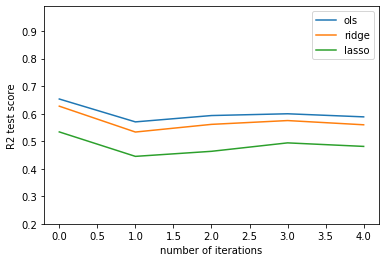

In [102]:
X = data
y = target
model_experiment(num_iter=5,
                     models=['ols', 'ridge', 'lasso'], alpha=10,
                     complexity='simple', degree=3)

In [122]:
def make_models(data, target, num_iter=5, models=['ols', 'lasso', 'ridge'],
               alpha=10, complexity='simple', degree=3):
    x_axis = np.arange(num_iter)
    ols_test = []
    lasso_test = []
    ridge_test = []
    sample_models = {}
    model_metrics = {}
    
    for i in range(num_iter):
        if complexity == 'simple':
            X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)
        elif complexity == 'polynomial':
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(data)
            X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
        elif complexity == 'poly_intx':
            poly_intx = PolynomialFeatures(degree=degree, interaction_only=True)
            Xpn = poly_intx.fit_transform(data)
            X_train, X_test, Y_train, Y_test = train_test_split(Xpn, target, test_size=0.2)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        
        if 'ols' in models:
            linreg = LinearRegression()
            ols_model_tr = linreg.fit(X_train, Y_train)
            train_pred = ols_model_tr.predict(X_train)
            test_pred = ols_model_tr.predict(X_test)
            
            sample_models['ols'] = ols_model_tr
            
            test_score = ols_model_tr.score(X_test, Y_test)
            ols_test.append(test_score)
            
            model_metrics['ols_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['ols_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['ols_test_r2'] = ols_model_tr.score(X_test, Y_test)
            model_metrics['ols_train_r2'] = ols_model_tr.score(X_train, Y_train)
        
        if 'lasso' in models:
            lasso = Lasso(alpha=alpha, max_iter=1000, normalize=True)
            lasso_model_tr = lasso.fit(X_train, Y_train)
            train_pred = lasso_model_tr.predict(X_train)
            test_pred = lasso_model_tr.predict(X_test)
            sample_models['lasso'] = lasso_model_tr
            test_score = lasso_model_tr.score(X_test, Y_test)
            lasso_test.append(test_score)
            model_metrics['lasso_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['lasso_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['lasso_test_r2'] = lasso_model_tr.score(X_test, Y_test)
            model_metrics['lasso_train_r2'] = lasso_model_tr.score(X_train, Y_train)
        if 'ridge' in models:
            ridge = Ridge(alpha=alpha, max_iter=1000, normalize=True)
            ridge_model_tr = ridge.fit(X_train, Y_train)
            train_pred = ridge_model_tr.predict(X_train)
            test_pred = ridge_model_tr.predict(X_test)
            sample_models['ridge'] = ridge_model_tr
            test_score = ridge_model_tr.score(X_test, Y_test)
            ridge_test.append(test_score)
            model_metrics['ridge_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['ridge_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['ridge_test_r2'] = ridge_model_tr.score(X_test, Y_test)
            model_metrics['ridge_train_r2'] = ridge_model_tr.score(X_train, Y_train)
        i += 1
    
    if 'ols' in models:
        plt.plot(ols_test, label='ols')
    if 'ridge' in models:
        plt.plot(ridge_test, label='ridge')
    if 'lasso' in models:
        plt.plot(lasso_test, label='lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    plt.ylim((0.40, 0.99))

    plt.legend()
    
    
                              
    return sample_models, model_metrics
        
        
        
        
        
        

({'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)},
 {'ols_train_rmse': 71.96134400319163,
  'ols_test_rmse': 49175035488236.84,
  'ols_test_r2': -1.4472122138392917e+23,
  'ols_train_r2': 0.7575746049998933})

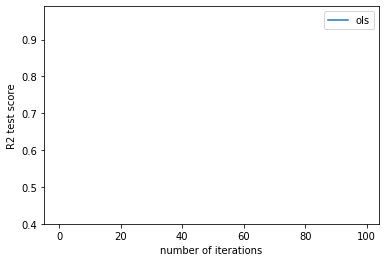

In [133]:
make_models(data, target, num_iter=10, models=['ols'],
               alpha=0.001, complexity='polynomial', degree=2)